# NLP Lab 3

---

## Mateusz Praski

In [ ]:
from spacy.tokenizer import Tokenizer
from spacy.lang.pl import Polish
from tqdm.notebook import tqdm
from collections import defaultdict
from random import randint, choice
from sklearn.metrics import ndcg_score
from morfeusz2 import Morfeusz

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib
import string
import requests
import json

In [2]:
matplotlib.rcParams['figure.figsize'] = (16, 7)

## Use the corpus from exercise no. 1.

In [3]:
df = pd.read_json("../../data/corpus.jsonl", lines=True)
df = df.set_index('_id').sort_index()
corpus = df['text']

## Use SpaCy tokenizer API to tokenize the text in the documents. Compute frequency list for each of the processed files. Aggregate the result to obtain one global frequency list. This frequency list gives you unigram statistics of the words appearing in the corpus.

In [4]:
nlp = Polish()
tokenizer = Tokenizer(nlp.vocab)

In [5]:
freq_list = {}

In [6]:
for doc in tqdm(tokenizer.pipe(corpus), total=len(corpus)):
    for token in doc:
        text = token.text
        freq_list[text] = freq_list.get(text, 0) + 1

  0%|          | 0/57638 [00:00<?, ?it/s]

In [7]:
questions = pd.read_json("../../data/queries.jsonl", lines=True)
questions = questions.set_index('_id').sort_index()['text']
questions.head()

_id
0    Co jest uważane za wydatek służbowy w podróży ...
1    Zgłaszanie wydatków biznesowych dla firmy bez ...
2    Przekazywanie pieniędzy z jednej kontroli bizn...
3    Posiadanie oddzielnego konta bankowego do prow...
4    Wydatki służbowe - ubezpieczenie samochodu pod...
Name: text, dtype: object

In [8]:
qa = pd.read_csv('../../data/test.tsv', sep='\t')

qa = qa.sort_values(by='query-id')
qa.head()

,query-id,corpus-id,score
0,8,566392,1
1,8,65404,1
2,15,325273,1
3,18,88124,1
4,26,285255,1


In [9]:
questions = questions[questions.index.isin(qa['query-id'])]
questions.head()

_id
8     Jak zdeponować czek wystawiony na współpracown...
15    Czy mogę wysłać przekaz pieniężny z USPS jako ...
18    1 EIN prowadzący działalność pod wieloma nazwa...
26    Ubieganie się o kredyt biznesowy i otrzymywani...
34                     401k Przelew po zamknięciu firmy
Name: text, dtype: object

In [10]:
qa_mapping = defaultdict(lambda: defaultdict(lambda: 0))

for _, row in qa.iterrows():
    query = row['query-id']
    corpus = row['corpus-id']
    qa_mapping[query][corpus] = 1

In [11]:
max_matches = qa.groupby('query-id')['corpus-id'].count().rename('count')
max_matches

query-id
8        2
15       1
18       1
26       2
34       1
        ..
10979    4
10994    2
11039    8
11054    2
11088    1
Name: count, Length: 648, dtype: int64

In [ ]:
!docker cp elastic_container:/usr/share/elasticsearch/config/certs/http_ca.crt .

In [13]:
ELASTIC_IP = 'https://localhost:9200'
INDEX = 'nlp-index'
auth = ('elastic', '"qwerty"')
cert = 'http_ca.crt'

In [14]:
def query_text(text, analyzer=None, limit=None, use_synonyms=True):
    url = f"{ELASTIC_IP}/{INDEX}/_search"
    if limit is not None:
        url += f"?size={limit}"

    index = "answer.with_synonyms" if use_synonyms else "answer.without_synonyms"

    body  = {
        "query": {
            "match": {
                index: {
                    "query": text,
                }
            }
        }
    }

    if analyzer is not None:
        body["query"]["match"][index]["analyzer"]  = analyzer

    rs = requests.get(url, json=body, auth=auth, verify=cert)
    if rs.status_code != 200:
        raise RuntimeError(f"{rs.status_code} - {rs.text}")
    return json.loads(rs.text)

In [15]:
def eval_answers(questions, n, analyzer=None, use_synonynms=True, query_func=query_text, **query_kwargs):
    no_questions = len(questions.index)
    rec = np.empty((no_questions, n), dtype=int)

    for index, row in tqdm(questions.iterrows(), total=no_questions):
        rs = query_func(row['text'], analyzer=analyzer, limit=5, use_synonyms=use_synonynms, **query_kwargs)

        recs = [qa_mapping[int(row['_id'])][int(rs['_id'])] for rs in rs['hits']['hits'][:n]]
        if len(recs) < n:
            recs += [0] * (n - len(recs))

        rec[index] = recs
    return rec

In [16]:
def eval_ndcg_scikit(questions, n, **eval_kwargs):
    perfect_answers = np.zeros((len(questions.index), n), dtype=int)

    for index, row in tqdm(questions.iterrows()):
        matches = min(max_matches.loc[row['_id']], n)
        vector = ([1] * matches) + ([0] * (n - matches))
        perfect_answers[index, :] = vector
        
    current_answers = eval_answers(questions, n, **eval_kwargs)
    
    return ndcg_score(perfect_answers, current_answers)

def eval_ndcg(questions, n, return_mean=True, **eval_kwargs):
    no_questions = len(questions.index)
    current_answers = eval_answers(questions, n, **eval_kwargs)

    perfect_answers = np.zeros((no_questions, n), dtype=int)

    for index, row in tqdm(questions.iterrows()):
        matches = min(max_matches.loc[row['_id']], n)
        vector = ([1] * matches) + ([0] * (n - matches))
        perfect_answers[index, :] = vector

    dcg_weights = np.log2(np.arange(2, n+2))
    dcg_weights = np.resize(dcg_weights, (no_questions, n))
    dcg = np.sum(current_answers / dcg_weights, axis=1)
    idcg = np.sum(perfect_answers / dcg_weights, axis=1)
    ndcg = dcg / idcg

    return ndcg.mean() if return_mean else ndcg

# 5. Apply a distortion function to the queries part of the corpus. In each query draw randomly one word and change one letter in the word to some other letter.

In [17]:
def distort(text):
    distort_pos = randint(0, len(text)-1)
    while not text[distort_pos].isalpha():
        distort_pos = randint(0, len(text)-1)
    
    return text[:distort_pos] + choice([x for x in string.ascii_lowercase if x != text[distort_pos]]) + text[distort_pos  + 1:] 

In [18]:
distort('letter')

'lettlr'

In [19]:
distorted_questions = questions.apply(distort).reset_index()
distorted_questions

,_id,text
0,8,Jak zdeponować czek wystawiony na współpracovn...
1,15,Czy mogę wysłać przenaz pieniężny z USPS jako ...
2,18,1 EIN prowadlący działalność pod wieloma nazwa...
3,26,Ubieganie się o krecyt biznesowy i otrzymywani...
4,34,401k Przelew po zamknięciu yirmy
...,...,...
643,10979,Zamknięcie pozycji futudes
644,10994,Strata netgo nie podzielona przez fundusze inw...
645,11039,Spłrć zadłużenie karty kredytowej lub zarób 40...
646,11054,Podatek od krótkoterminowych zysków kapitałowy...


# 6. Compute nDCG@10 for the distorted queris, using the same approach as in lab 2. This result will be the baseline for the other methods.

In [20]:
eval_ndcg(distorted_questions, n=10)

  0%|          | 0/648 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0.15884010867532353

# 7. Install Morfeusz (Binding dla Pythona) and use it to find all words from the queries that do not appear in that dictionary.

In [21]:
distorted_questions

,_id,text
0,8,Jak zdeponować czek wystawiony na współpracovn...
1,15,Czy mogę wysłać przenaz pieniężny z USPS jako ...
2,18,1 EIN prowadlący działalność pod wieloma nazwa...
3,26,Ubieganie się o krecyt biznesowy i otrzymywani...
4,34,401k Przelew po zamknięciu yirmy
...,...,...
643,10979,Zamknięcie pozycji futudes
644,10994,Strata netgo nie podzielona przez fundusze inw...
645,11039,Spłrć zadłużenie karty kredytowej lub zarób 40...
646,11054,Podatek od krótkoterminowych zysków kapitałowy...


In [22]:
morf = Morfeusz()

def find_incorrect_word(text):
    # I did not want to assume that there's only one wrong word - in reality we wouldn't know that
    analysis = morf.analyse(text)
    
    invalid_words = []
    
    for result in analysis:
        if result[2][2] == 'ign':
            invalid_words.append(result[2][0])
    return invalid_words

In [23]:
find_incorrect_word(distorted_questions['text'].iloc[0])

['współpracovnika']

In [24]:
N = sum(freq_list.values())


def correct_word(word):
    
    def candidates(word):
        letters    = 'aąbcćdeęfghijklłmnńoópqrsśtuvwxyzźż'
        splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
        deletes    = [L + R[1:]               for L, R in splits if R]
        transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
        replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
        inserts    = [L + c + R               for L, R in splits for c in letters]
        return set(deletes + transposes + replaces + inserts)

    def prob(word):
        return freq_list.get(word, 0) / N
    
    return max(candidates(word), key=prob)

In [25]:
correct_word('dojej')

'mojej'

In [26]:
correct_word('fiimie')

'firmie'

In [27]:
def correct(sentence, word_corrector=correct_word):
    words = find_incorrect_word(sentence)
    for word in words:
        fixed_word = word_corrector(word)
        sentence = sentence.replace(word, fixed_word)
    return sentence

In [28]:
distorted_questions['text'].iloc[0]

'Jak zdeponować czek wystawiony na współpracovnika w mojej firmie na moje konto firmowe?'

In [29]:
correct(distorted_questions['text'].iloc[0])

'Jak zdeponować czek wystawiony na współpracownika w mojej firmie na moje konto firmowe?'

In [30]:
%%timeit
correct(distorted_questions['text'].iloc[0])

354 µs ± 35.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [31]:
distorted_questions.head()

,_id,text
0,8,Jak zdeponować czek wystawiony na współpracovn...
1,15,Czy mogę wysłać przenaz pieniężny z USPS jako ...
2,18,1 EIN prowadlący działalność pod wieloma nazwa...
3,26,Ubieganie się o krecyt biznesowy i otrzymywani...
4,34,401k Przelew po zamknięciu yirmy


In [32]:
fixed_questions = distorted_questions.copy()
fixed_questions['text'] = fixed_questions['text'].apply(correct)

In [33]:
fixed_questions.head()

,_id,text
0,8,Jak zdeponować czek wystawiony na współpracown...
1,15,Czy mogę wysłać przekaz pieniężny z UPS jako f...
2,18,1 EI prowadzący działalność pod wieloma nazwam...
3,26,Ubieganie się o kredyt biznesowy i otrzymywani...
4,34,401k Przelew po zamknięciu firmy


In [34]:
eval_ndcg(fixed_questions, n=10)

  0%|          | 0/648 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0.16030256334692877

# 10. Use ElasticSearch's fuzzy match and compute nDCG@10 for this approach.

In [35]:
def fuzzy_text(text, analyzer=None, limit=None, use_synonyms=True, fuzziness=1):
    url = f"{ELASTIC_IP}/{INDEX}/_search"
    if limit is not None:
        url += f"?size={limit}"

    index = "answer.with_synonyms" if use_synonyms else "answer.without_synonyms"

    body  = {
        "query": {
            "match": {
                index: {
                    "query": text,
                    "fuzziness": fuzziness
                }
            }
        }
    }

    if analyzer is not None:
        body["query"]["match"][index]["analyzer"]  = analyzer

    rs = requests.get(url, json=body, auth=auth, verify=cert)
    if rs.status_code != 200:
        raise RuntimeError(f"{rs.status_code} - {rs.text}")
    return json.loads(rs.text)

In [36]:
from time import time

def measure_time(func):
    start = time()
    res = func()
    end = time()
    return f"Time: {f'{(end - start):.2f}s': <8}, NDCG@10 {res:.2%}"

In [37]:
def fix_and_eval(queries, word_corrector=correct_word):
    fixed_questions = queries.copy()
    fixed_questions['text'] = fixed_questions['text'].apply(lambda x: correct(x, word_corrector=word_corrector))
    return eval_ndcg(fixed_questions, n=10)

In [38]:
import re
from collections import Counter

def correct_word_len2(word):
    def prob(word):
        return freq_list.get(word, 0) / N
    
    def candidates(word):
        return known([word]) or known(edits1(word)) or known(edits2(word)) or [word]

    def known(words):
        "The subset of `words` that appear in the dictionary of WORDS."
        return set(w for w in words if w in freq_list)
    
    def edits1(word):
        "All edits that are one edit away from `word`."
        letters    = 'aąbcćdeęfghijklłmnńoópqrsśtuvwxyzźż'
        splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
        deletes    = [L + R[1:]               for L, R in splits if R]
        transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
        replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
        inserts    = [L + c + R               for L, R in splits for c in letters]
        return set(deletes + transposes + replaces + inserts)
    
    def edits2(word):
        "All edits that are two edits away from `word`."
        return (e2 for e1 in edits1(word) for e2 in edits1(e1))

    return max(candidates(word), key=prob)

In [39]:
scores = {}

In [40]:
scores['distorded questions'] = measure_time(lambda: eval_ndcg(distorted_questions, n=10))

  0%|          | 0/648 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [41]:
scores['levenshtein_1'] = measure_time(lambda: fix_and_eval(distorted_questions))

  0%|          | 0/648 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [42]:
scores['levenshtein_2'] = measure_time(lambda: fix_and_eval(distorted_questions, word_corrector=correct_word_len2))

  0%|          | 0/648 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [43]:
scores['fuzzy_1'] = measure_time(lambda: eval_ndcg(distorted_questions, n=10, query_func=fuzzy_text))

  0%|          | 0/648 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [44]:
scores['fuzzy_auto'] = measure_time(lambda: eval_ndcg(distorted_questions, n=10, query_func=fuzzy_text, fuzziness='AUTO'))

  0%|          | 0/648 [00:00<?, ?it/s]

0it [00:00, ?it/s]

# 11. Compare the results of baseline with the 2 implemented methods. Take into account the nDCG score and the performance of the methods.

In [45]:
for k, v in scores.items():
    print(f"{k: <20} ==> {v}")

distorded questions  ==> Time: 11.13s  , NDCG@10 15.88%
levenshtein_1        ==> Time: 11.25s  , NDCG@10 16.03%
levenshtein_2        ==> Time: 14.72s  , NDCG@10 17.93%
fuzzy_1              ==> Time: 15.43s  , NDCG@10 14.36%
fuzzy_auto           ==> Time: 18.93s  , NDCG@10 14.59%


# Draw conclusions regarding (2 points):

## The distribution of words in the corpus

In [60]:
x = np.sort(np.array(list(freq_list.values())))

Text(0.5, 1.0, 'Rank of the word vs frequency')

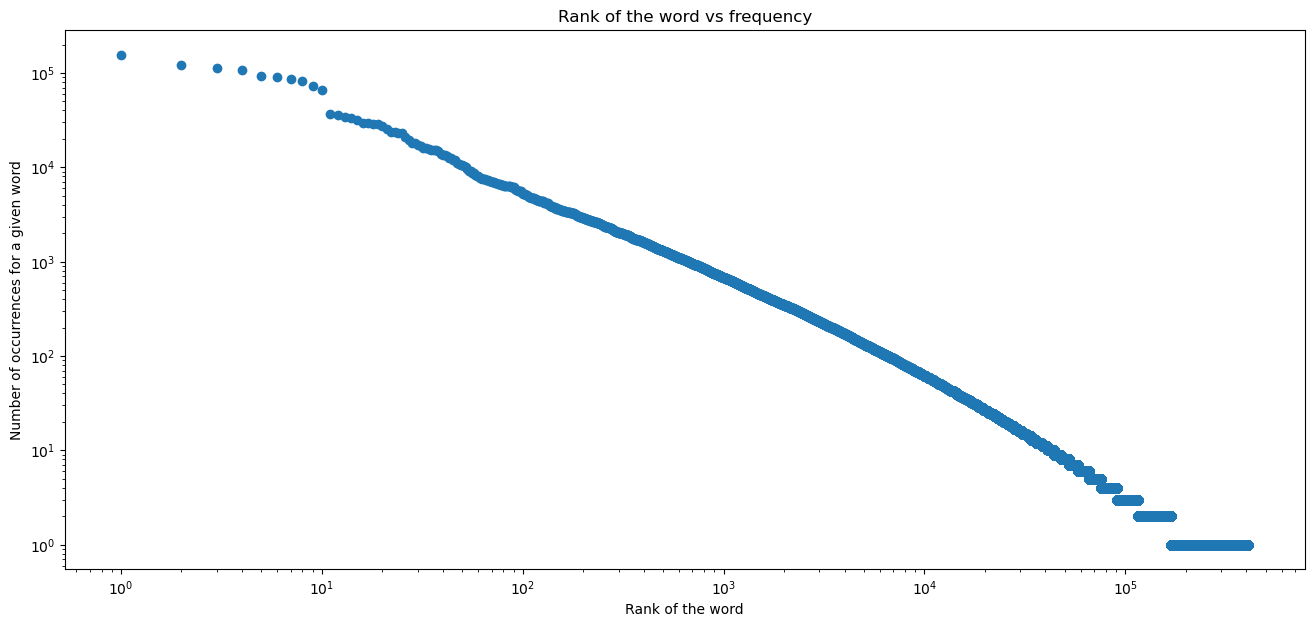

In [66]:
plt.scatter(np.arange(len(freq_list), 0, -1), x)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Number of occurrences for a given word')
plt.xlabel('Rank of the word')
plt.title('Rank of the word vs frequency')

Text(0.5, 1.0, 'Rank of the word vs frequency')

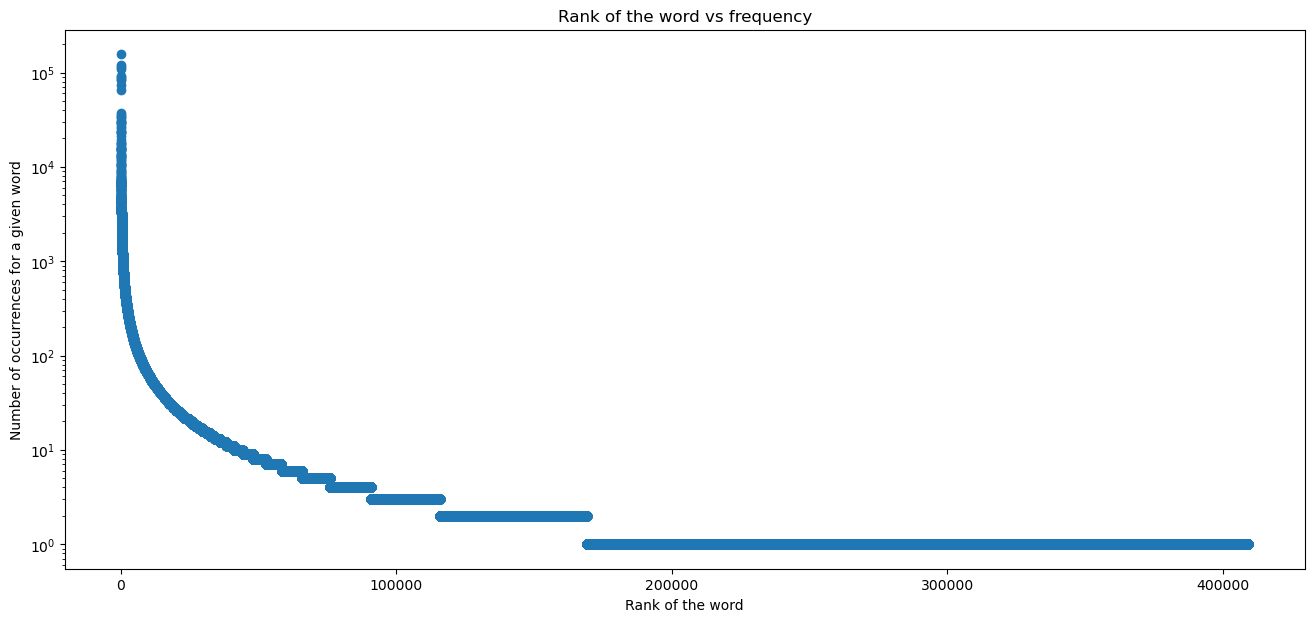

In [67]:
plt.scatter(np.arange(len(freq_list), 0, -1), x)
plt.yscale('log')
plt.ylabel('Number of occurrences for a given word')
plt.xlabel('Rank of the word')
plt.title('Rank of the word vs frequency')

We can see that words distribution in the corpus does not follow normal distribution. Most popular words in the corpus occur far more often than the rest. We can see that more than 80% of the words occur in the corpus less than 10 times (the corpus has over 50k sentences!)

# The performance of your method compared to ElasticSearch & the results provided by your method compared to ElasticSearch

In [68]:
for k, v in scores.items():
    print(f"{k: <20} ==> {v}")

distorded questions  ==> Time: 11.13s  , NDCG@10 15.88%
levenshtein_1        ==> Time: 11.25s  , NDCG@10 16.03%
levenshtein_2        ==> Time: 14.72s  , NDCG@10 17.93%
fuzzy_1              ==> Time: 15.43s  , NDCG@10 14.36%
fuzzy_auto           ==> Time: 18.93s  , NDCG@10 14.59%


For Levenshtein automaton for distance=1 we get almost the same time as standard query, and improvement by 0.2 percentage.

Levenshtein automaton with distance=2 manages to get the highest result with increase of over 2 percentage to the baseline, while taking similar time to ES fuzzy search.

Interestingly ES fuzzy search despite taking the longest time, didn't manage to improve results, which is interesting as it also based on a levenshtein distance 

# the validity of the obtained corrections.

In [72]:
questions

_id
8        Jak zdeponować czek wystawiony na współpracown...
15       Czy mogę wysłać przekaz pieniężny z USPS jako ...
18       1 EIN prowadzący działalność pod wieloma nazwa...
26       Ubieganie się o kredyt biznesowy i otrzymywani...
34                        401k Przelew po zamknięciu firmy
                               ...                        
10979                           Zamknięcie pozycji futures
10994    Strata netto nie podzielona przez fundusze inw...
11039    Spłać zadłużenie karty kredytowej lub zarób 40...
11054    Podatek od krótkoterminowych zysków kapitałowy...
11088    Czy wymagane jest, aby prawnik stworzył/nadzor...
Name: text, Length: 648, dtype: object

In [74]:
for i in range(5):
    print(f"Original question:  {questions.iloc[i]}")
    print(f"Distorted question: {distorted_questions['text'].iloc[i]}")
    print(f"Corrected question: {fixed_questions['text'].iloc[i]}")
    print("===================================================================")

Original question:  Jak zdeponować czek wystawiony na współpracownika w mojej firmie na moje konto firmowe?
Distorted question: Jak zdeponować czek wystawiony na współpracovnika w mojej firmie na moje konto firmowe?
Corrected question: Jak zdeponować czek wystawiony na współpracownika w mojej firmie na moje konto firmowe?
Original question:  Czy mogę wysłać przekaz pieniężny z USPS jako firma?
Distorted question: Czy mogę wysłać przenaz pieniężny z USPS jako firma?
Corrected question: Czy mogę wysłać przekaz pieniężny z UPS jako firma?
Original question:  1 EIN prowadzący działalność pod wieloma nazwami firm
Distorted question: 1 EIN prowadlący działalność pod wieloma nazwami firm
Corrected question: 1 EI prowadzący działalność pod wieloma nazwami firm
Original question:  Ubieganie się o kredyt biznesowy i otrzymywanie go
Distorted question: Ubieganie się o krecyt biznesowy i otrzymywanie go
Corrected question: Ubieganie się o kredyt biznesowy i otrzymywanie go
Original question:  401k

This method manages very well to fix the errors in the text, however it struggles with proper nouns. For example, it 'corrected' UPSP to UPS